<a href="https://colab.research.google.com/github/bsh0137/GAN/blob/main/GAN_mnist_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

from scipy.stats import norm
import numpy as np

In [ ]:
batch_size = 100
original_dim = 784 #28*28
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0

In [ ]:
def sampling(args: tuple):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
  return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
x = Input(shape=(original_dim,), name="input") # 인코더 입력
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder") # 케라스 모델로 인코더를 정의함.
encoder.summary()

In [ ]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

In [ ]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

In [ ]:
x_test_encoded = encoder.predict(x_test)[0]

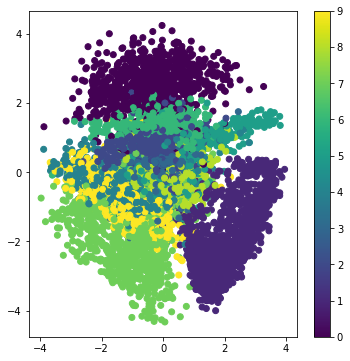

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
print(x_test_encoded[0])
print(x_test_encoded[1])

[[-1.1839451  -3.086674  ]
 [-0.49228054  0.63882387]
 [ 2.8276782  -2.2376854 ]
 ...
 [-0.18103403 -1.0922208 ]
 [ 2.0508652   0.96535504]
 [ 0.30064872  1.5947301 ]]
[[-4.1158895 -3.0188093]
 [-5.8326535 -5.958765 ]
 [-3.4621024 -3.238426 ]
 ...
 [-5.2083488 -5.103556 ]
 [-4.641487  -5.0535336]
 [-5.3277907 -5.482547 ]]


In [ ]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [ ]:
print(grid_x)
print(grid_y)
print(np.linspace(0.05, 0.95, n))

[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
[0.05       0.11428571 0.17857143 0.24285714 0.30714286 0.37142857
 0.43571429 0.5        0.56428571 0.62857143 0.69285714 0.75714286
 0.82142857 0.88571429 0.95      ]


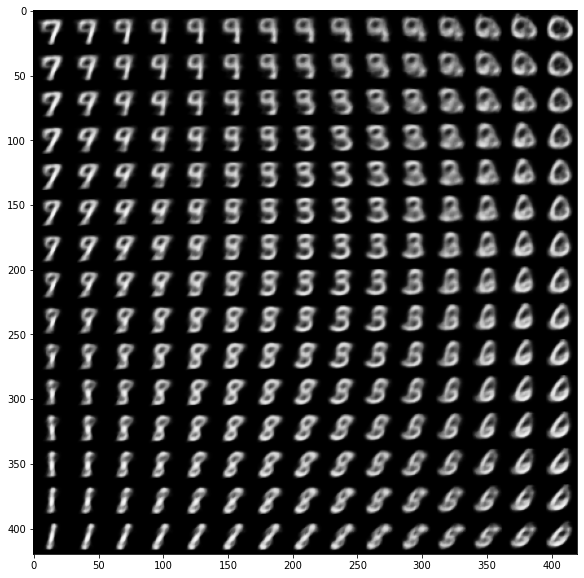

In [ ]:
figure = np.zeros((digit_size * n, digit_size * n))
for i, xi in enumerate(grid_x):
  for j, yj in enumerate(grid_y):
    z_sample = np.array([[xi, yj]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded.reshape(digit_size, digit_size)
    figure[i * digit_size : (i+1) * digit_size,
           j * digit_size : (j+1) * digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()